In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_pecentage_error(y_true, y_pred):
    "Calculates MAPE given y_true & y_pred"
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-t_pred)/y_true))*100

In [120]:
pjme = pd.read_csv('data sources/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


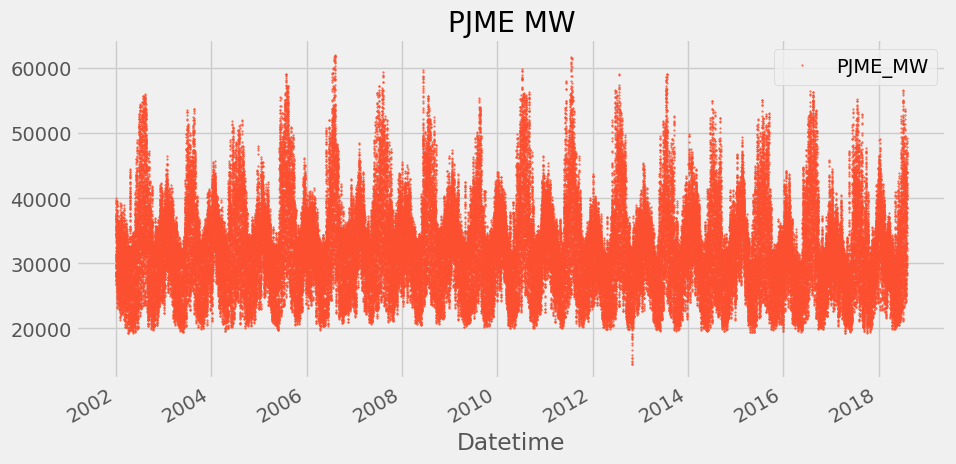

In [121]:
clr_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=clr_pal[1],
          title="PJME MW")

plt.show()

## Time Series Features

In [122]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(
    categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    ordered=True
)

def create_features(df, label=None):
    """
    Creates time series features from a DatetimeIndex.
    """
    df = df.copy()

    
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek                   
    df['weekday'] = df['date'].dt.day_name().astype(cat_type)   
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month                           
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week         
    df['date_offset'] = (df['date'].dt.month * 100 + df['date'].dt.day - 320) % 1300

    df['season'] = pd.cut(
        df['date_offset'],
        [0, 300, 602, 900, 1300],
        labels=['Spring', 'Summer', 'Fall', 'Winter']
    )

    X = df[['hour','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear','weekday','season']]

    if label is not None:
        y = df[label]
        return X, y
    return X

# usage
X, y = create_features(pjme, label="PJME_MW")
features_and_target = pd.concat([X, y], axis=1)

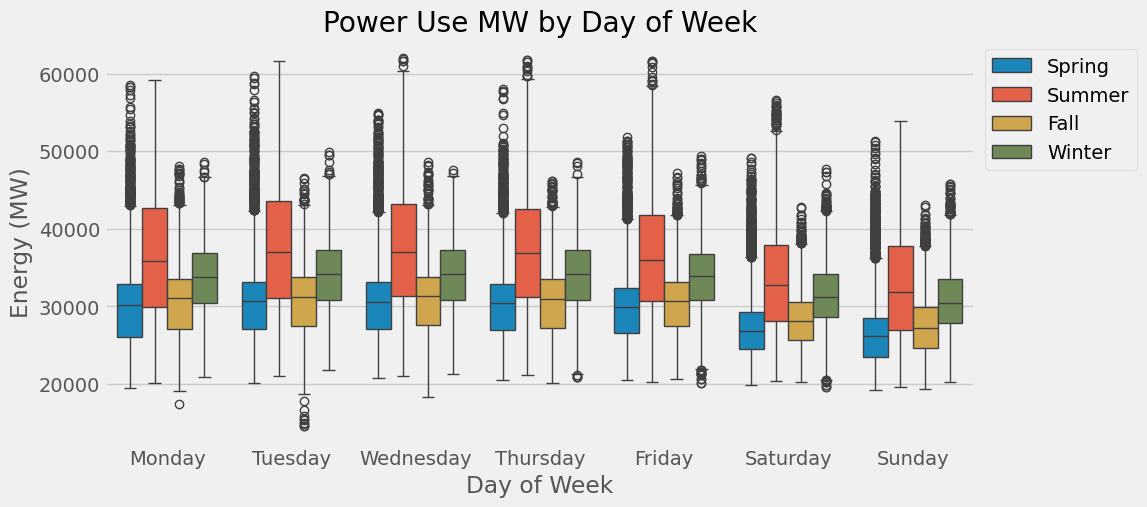

In [123]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Train / Test Split

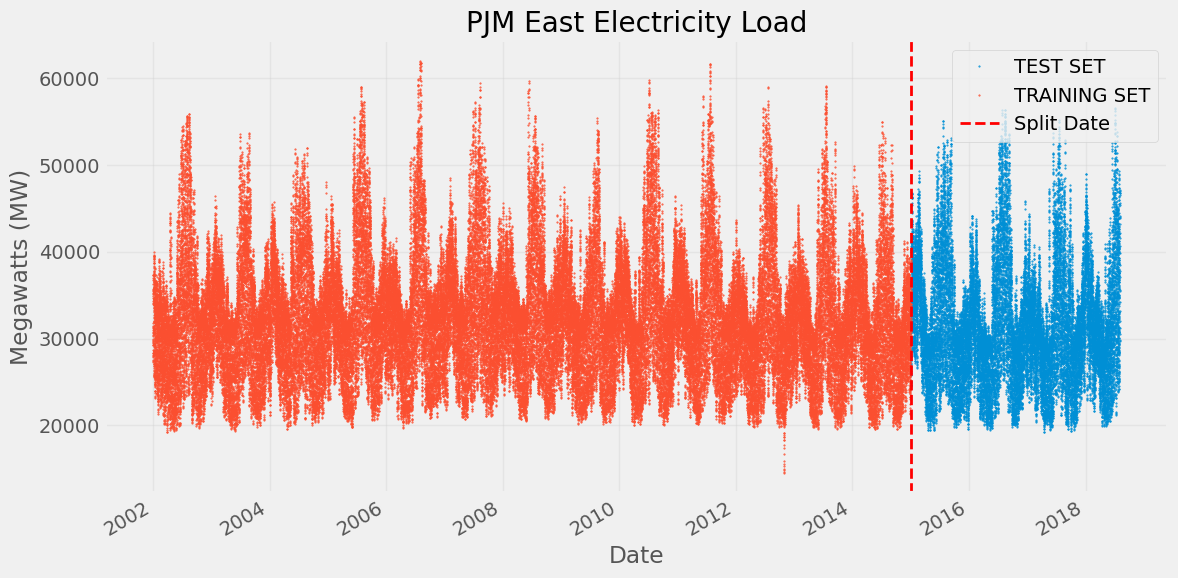

In [124]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()


ax = pjme_test.rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(
        pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
        how='outer'
    ) \
    .plot(figsize=(12, 6), title='PJM East Electricity Load', style='.', ms=1)


plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', lw=2, label='Split Date')

plt.xlabel('Date')
plt.ylabel('Megawatts (MW)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Simple Prophet Model

- Datetime column named: ds
- target: y

In [125]:
# format data for prophet model using ds & y

pjme_train_prophet = pjme_train.reset_index() .rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

In [126]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

22:50:33 - cmdstanpy - INFO - Chain [1] start processing
22:51:27 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 6.29 s, sys: 201 ms, total: 6.49 s
Wall time: 1min


In [127]:
# predict on test set w model

pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})
pjme_test_forecast = model.predict(pjme_test_prophet)

In [128]:
pjme_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31207.512213,23948.787856,32688.982882,31207.512213,31207.512213,-2847.900473,-2847.900473,-2847.900473,-4430.297380,...,1281.379746,1281.379746,1281.379746,301.017161,301.017161,301.017161,0.0,0.0,0.0,28359.611741
1,2015-01-01 02:00:00,31207.474749,22267.115484,31295.566669,31207.474749,31207.474749,-4352.227873,-4352.227873,-4352.227873,-5927.158022,...,1272.622556,1272.622556,1272.622556,302.307593,302.307593,302.307593,0.0,0.0,0.0,26855.246876
2,2015-01-01 03:00:00,31207.437285,21596.484863,30165.079144,31207.437285,31207.437285,-5223.927199,-5223.927199,-5223.927199,-6790.226343,...,1262.659616,1262.659616,1262.659616,303.639528,303.639528,303.639528,0.0,0.0,0.0,25983.510086
3,2015-01-01 04:00:00,31207.399820,21384.139884,30182.396946,31207.399820,31207.399820,-5365.534882,-5365.534882,-5365.534882,-6922.162373,...,1251.614499,1251.614499,1251.614499,305.012992,305.012992,305.012992,0.0,0.0,0.0,25841.864939
4,2015-01-01 05:00:00,31207.362356,21754.856860,31075.500041,31207.362356,31207.362356,-4691.271746,-4691.271746,-4691.271746,-6237.322742,...,1239.622986,1239.622986,1239.622986,306.428011,306.428011,306.428011,0.0,0.0,0.0,26516.090610


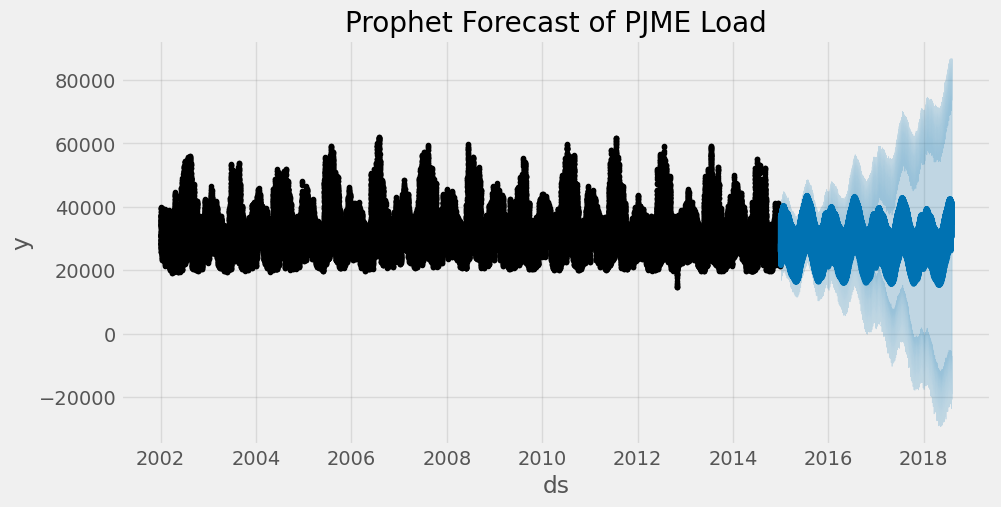

In [129]:
# prophet forecast plot

fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(pjme_test_forecast, ax=ax)
ax.set_title('Prophet Forecast of PJME Load')
plt.show()

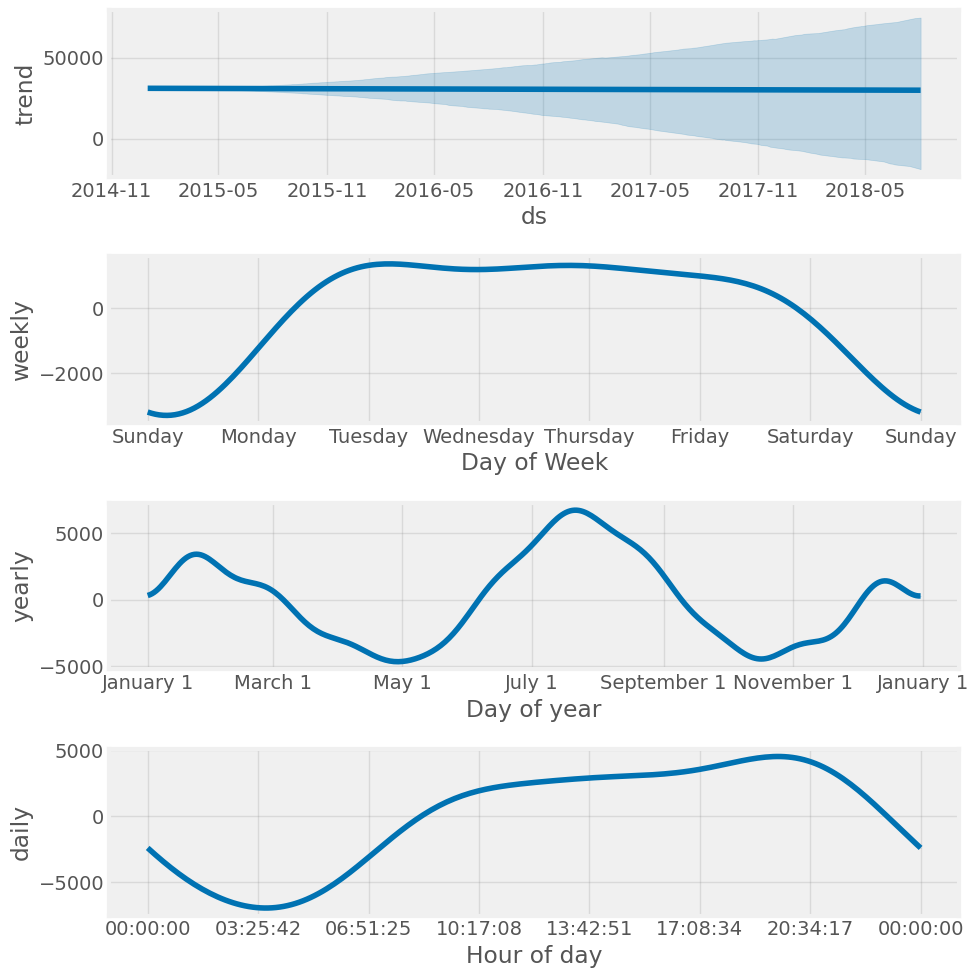

In [130]:
fig = model.plot_components(pjme_test_forecast,figsize=(10,10))
plt.show()

## Compare Forecast to Actuals

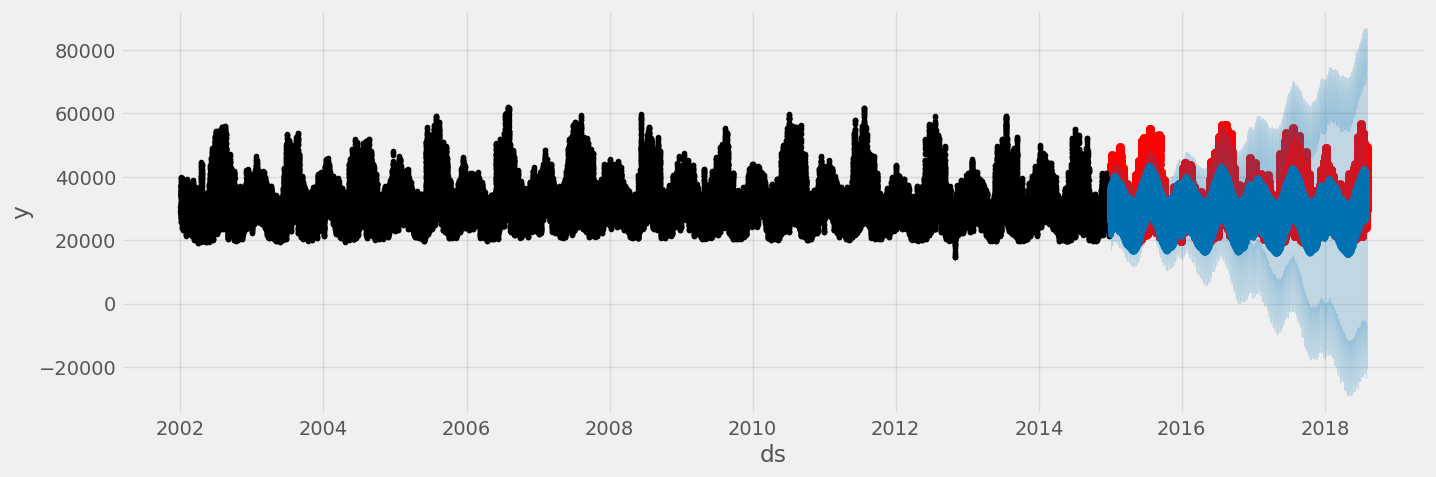

In [131]:
# plot of forecast w actuals

f, ax = plt.subplots(figsize = (15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color = 'r')
fig = model.plot(pjme_test_forecast, ax=ax)

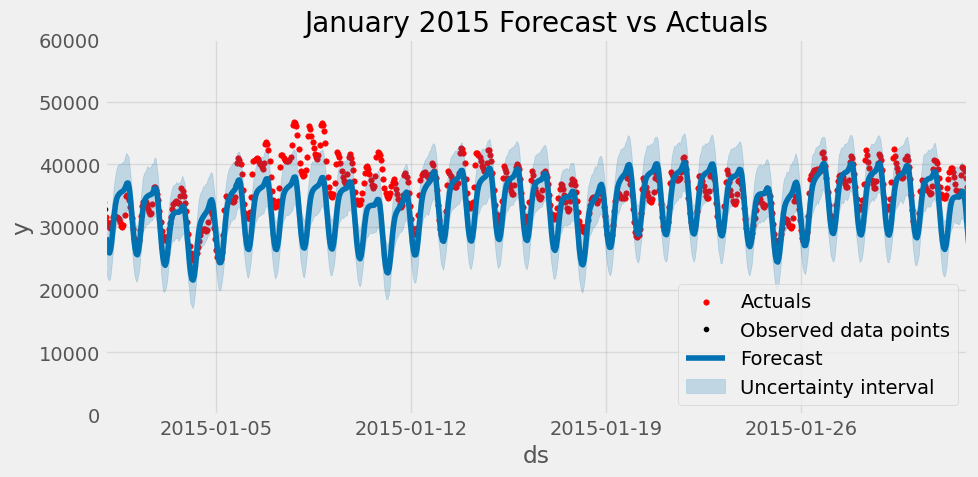

In [132]:
pjme_test.index = pd.to_datetime(pjme_test.index).tz_localize(None)
pjme_test_forecast['ds'] = pd.to_datetime(pjme_test_forecast['ds'], errors='coerce').dt.tz_localize(None)

start = pd.Timestamp('2015-01-01')
end   = pd.Timestamp('2015-02-01')

# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='red', s=15, label='Actuals')
model.plot(pjme_test_forecast, ax=ax)
ax.set_xlim(start, end)
ax.set_ylim(0, 60000)
ax.set_title('January 2015 Forecast vs Actuals')
ax.legend()
plt.tight_layout()
plt.show()

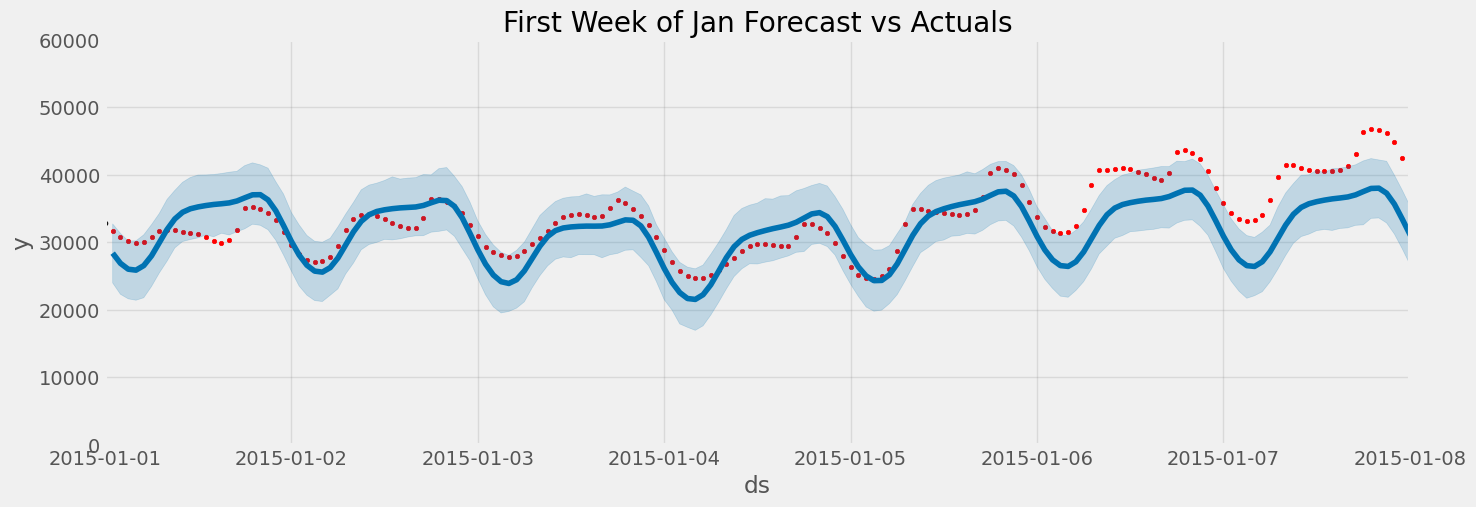

In [133]:
# plot of forecast w actuals - zoomed in 

pjme_test.index = pd.to_datetime(pjme_test.index)
pjme_test_forecast['ds'] = pd.to_datetime(pjme_test_forecast['ds'])

#datetime bounds
lower = pd.Timestamp('2015-01-01')
upper = pd.Timestamp('2015-01-08')

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', s=10, label='Actuals')
model.plot(pjme_test_forecast, ax=ax)
ax.set_xlim(lower, upper)
ax.set_ylim(0, 60000)
ax.set_title('First Week of Jan Forecast vs Actuals')
#ax.legend()
plt.show()


## Evaluation of the model w error metrics

In [134]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], 
                           y_pred=pjme_test_forecast['yhat']))

np.float64(6617.434811308175)

In [135]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_forecast['yhat'])

5182.5842366525885

In [136]:
 # mean absolute percentage error (MAPE) function

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        perc = np.abs((y_true - y_pred) / y_true) * 100
        perc = perc[~np.isinf(perc)]
        perc = perc[~np.isnan(perc)]
    return perc.mean()

mape_val = mape(pjme_test['PJME_MW'], pjme_test_forecast['yhat'])
print(f"MAPE: {mape_val:,.2f}%")

MAPE: 16.51%


## Holidays

In [137]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                           columns=['holidays'])

holiday_df = holiday_df.reset_index().rename(columns={'indedx': 'ds'})

In [138]:
%%time

cal = calendar()
hol_ser = cal.holidays(
    start=pjme.index.min(), 
    end=pjme.index.max(), 
    return_name=True
)

# Tidy to Prophet format
holiday_df = (hol_ser
              .to_frame(name='holiday')
              .reset_index()
              .rename(columns={'index': 'ds'}))

# Ensure correct dtypes (tz-naive datetimes + strings) and no NaNs
holiday_df['ds'] = pd.to_datetime(holiday_df['ds']).dt.tz_localize(None)
holiday_df['holiday'] = holiday_df['holiday'].astype(str)
holiday_df = holiday_df.dropna(subset=['ds', 'holiday']).drop_duplicates(subset=['ds', 'holiday'])


# Fit Prophet with holidays
model_w_holidays = Prophet(holidays=holiday_df)
model_w_holidays.fit(pjme_train_prophet)

22:51:41 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 7.28 s, sys: 247 ms, total: 7.52 s
Wall time: 57.5 s


In [139]:
# predict on training set w model

pjme_test_forecast_with_hols = model_w_holidays.predict(df=pjme_test_prophet)

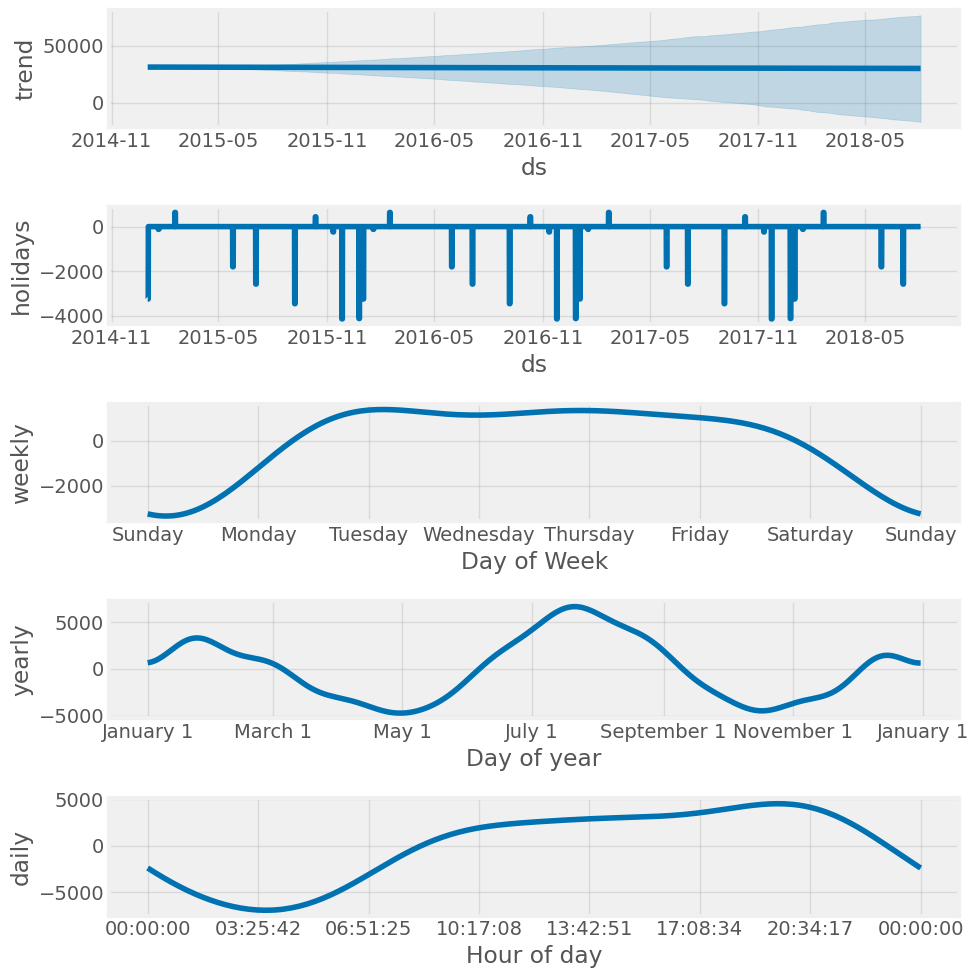

In [140]:
fig = model_w_holidays.plot_components(pjme_test_forecast_with_hols, figsize=(10,10))
plt.show()

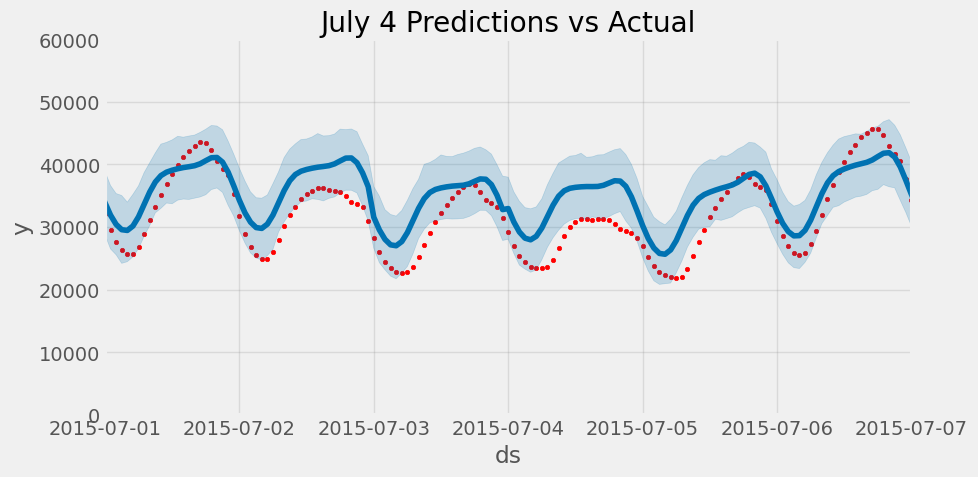

In [141]:
future_test_hols = pd.DataFrame({
    "ds": pd.to_datetime(pjme_test.index).tz_localize(None)
})
pjme_test_forecast_hols = model_with_holidays.predict(future_test_hols)

start, end = pd.Timestamp('2015-07-01'), pd.Timestamp('2015-07-07')

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='red', s=10, label='Actuals')
model_with_holidays.plot(pjme_test_forecast_hols, ax=ax)
ax.set_xlim(start, end)
ax.set_ylim(0, 60000)
ax.set_title('July 4 Predictions vs Actual')
#ax.legend()
plt.tight_layout()
plt.show()

In [142]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_forecast_with_hols['yhat']))

np.float64(6636.7578131451)

In [143]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_forecast_with_hols['yhat'])

5199.4450274816645

In [144]:
 # mean absolute percentage error (MAPE) function

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test_forecast_with_hols['yhat']
)

print(f"MAPE: {mape:.2f}%")

MAPE: 16.56%


## Predict into Future

In [145]:
future = model.make_future_dataframe(periods=365*24, 
                                     freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [146]:
forecast[['ds','yhat']]

,ds,yhat
0,2015-01-01 01:00:00,25546.676037
1,2015-01-01 02:00:00,24044.720080
2,2015-01-01 03:00:00,23175.158223
3,2015-01-01 04:00:00,23035.497719
4,2015-01-01 05:00:00,23711.432836
...,...,...
8755,2015-12-31 20:00:00,37087.848020
8756,2015-12-31 21:00:00,36318.054051
8757,2015-12-31 22:00:00,34691.833620
8758,2015-12-31 23:00:00,32487.023150


# End